In [75]:
import urllib.request
import requests
import pandas as pd
import seaborn as sns
import geopandas as gpd
import json
from matplotlib import pyplot as plt
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from shapely.geometry import MultiPolygon, Polygon, Point

In [152]:
MAIRIES_FILE = 'data/mairies-martinique.geojson'
COMMUNES_FILES = 'data/communes-martinique.geojson'
INSEE_LOCAL_FILE = 'output-tmp/insee.xlsx'

In [169]:
# get data, see 2022-11-02
df = pd.read_excel(INSEE_LOCAL_FILE, skiprows=5)
df_mq = df.loc[df.DEP == '972'].dropna(axis=1).copy()
df_mq['shrink'] = (df_mq['PMUN19'] - df_mq['PMUN06']) / df_mq['PMUN06']

/tmp/ipykernel_280101/319286219.py:14: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for polygon in list(z):
/tmp/ipykernel_280101/319286219.py:14: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in list(z):
/home/glefait/.virtualenvs/notebooks/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


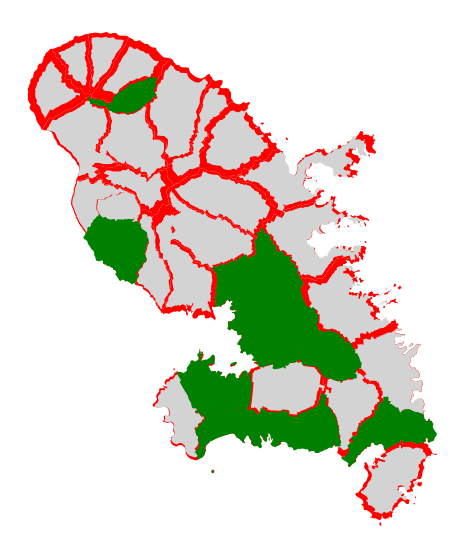

In [191]:
def shrink_toward_center(polygon, center, shrink):
    points = []
    cx, cy = center.coords[0]
    points = []
    for x, y in polygon.exterior.coords:
        points.append(Point(x + (x-cx) * shrink, y + (y-cy) * shrink))
    poly = Polygon(points)
    return poly


def do_shrink(z, center, shrink):
    polygons = []
    if 'MultiPolygon' == z.geom_type:
        for polygon in list(z):
            polygons.append(shrink_toward_center(polygon, center, shrink))
        output = MultiPolygon(polygons)
    else:
        output = shrink_toward_center(z, center, shrink)
    return output


def do_wut(x):
    return do_shrink(x['geometry'], x['center'], x['shrink'])



gdf_mq = gpd.read_file(COMMUNES_FILES)
initial_crs = gdf_mq.geometry.crs.srs

ax = gdf_mq.plot(figsize=(10,10), color="red")
ax.axis('off')

gdf_mq['geometry'] = gdf_mq['geometry'].to_crs('epsg:5756')
gdf_mq['center'] = gdf_mq['geometry'].centroid

gdf_mq = gdf_mq.merge(df_mq.rename(columns={'CODGEO': 'code'})[['code', 'shrink']], on='code')

gdf_mq['geometry']  = gdf_mq[['geometry', 'center', 'shrink']].apply(lambda x: do_wut(x), axis=1)
gdf_mq['geometry'] = gdf_mq['geometry'].to_crs(initial_crs)
gdf_mq['center'] = gdf_mq['center'].to_crs(initial_crs)

gdf_mq.loc[gdf_mq.shrink < 0].plot(color="lightgrey", ax=ax)

gdf_mq.loc[gdf_mq.shrink >= 0].plot(color="green", ax=ax)

plt.savefig('output/2022-11-03.png', facecolor='white')